# GOLEM Fast Spectrometry Analysis

This notebook demonstrates analysis of GOLEM tokamak diagnostic data using the `golem_data_loader` module.

## Features of the data loader:
- **Type-safe**: Full type annotations for better IDE support
- **Robust error handling**: Automatic retries with configurable delays
- **Flexible**: Load all or specific spectroscopy lines
- **Well-documented**: Comprehensive docstrings and examples
- **Easy to use**: Simple API with sensible defaults

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from scipy import fft

# Import the GOLEM data loader module
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 18,  # x/y labels
        "axes.titlesize": 18,  # subplot titles
        "xtick.labelsize": 14,  # x tick labels
        "ytick.labelsize": 14,  # y tick labels
        "legend.fontsize": 14,  # legends
        "figure.titlesize": 16,  # suptitle
    }
)


In [2]:
shotno = 50739

## Load Data from GOLEM Web Server

Using the `golem_data_loader` module to fetch diagnostic data with automatic retry logic and error handling.

In [3]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format for backward compatibility
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2025-12-03 15:49:04,638 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2025-12-03 15:49:04,642 - golem_data_loader.golem_data_loader - INFO - Hα: loaded 19999 rows, columns = ['    0', '-0.000']
2025-12-03 15:49:04,720 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch5.csv
2025-12-03 15:49:04,723 - golem_data_loader.golem_data_loader - INFO - Cl II 479.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2025-12-03 15:49:04,851 - golem_data_loader.golem_data_loader - INFO - Successfully loaded He I 588nm spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch7.csv
2025-12-03 15:49:04,854 - golem_data_loader.golem_data_loader - INFO - He I 588nm: loaded 19999 rows, columns =

Hα: loaded 19999 rows
Cl II 479.5nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


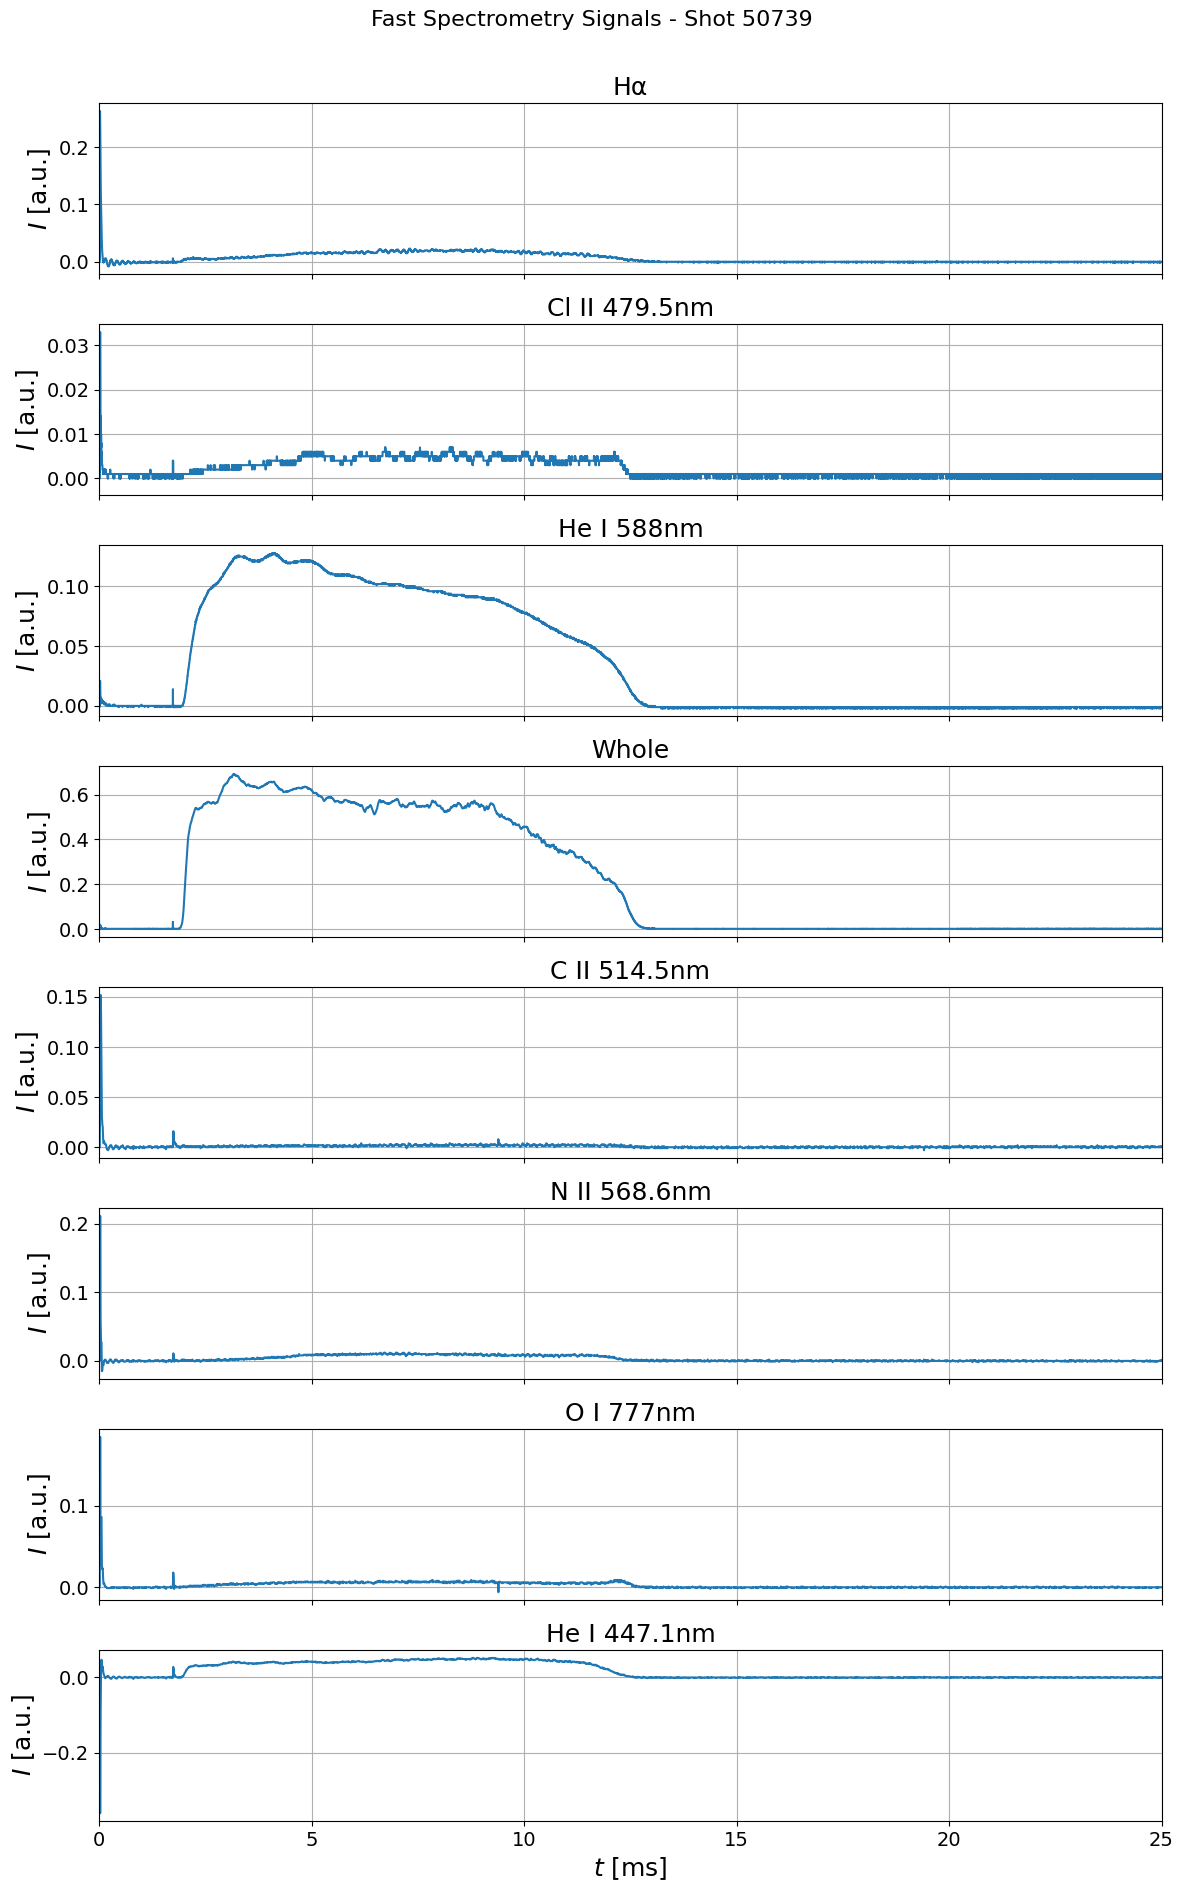

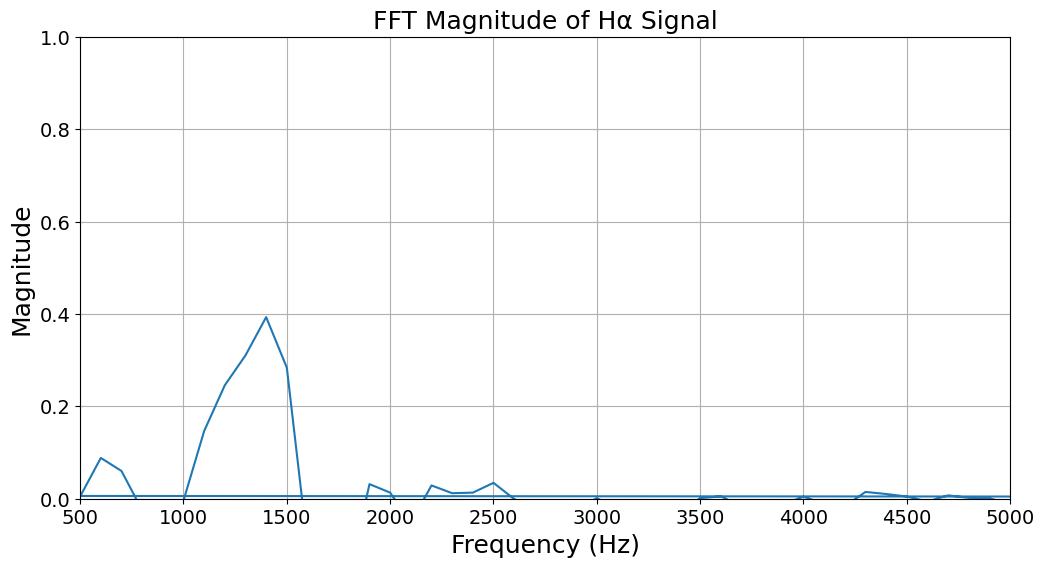

In [13]:
FFT_range = (3500, 4500) 

# One figure, eight stacked subplots (share X for alignment)
%matplotlib inline
fig, axes = plt.subplots(nrows=8, sharex=True, figsize=(12, 20))

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

for ax, (label, df) in zip(axes, data.items()):
    t = df.iloc[:, 0] * 1e3  # convert to ms
    u = df.iloc[:, 1]
    ax.plot(t, u, label=label)
    # ax.plot(t, butter_lowpass_filter(u, 1000, 100e3), label=label)
    # ax.plot(t, u, color="gray", alpha=0.5, label="Noise (Whole)", marker=".")
    ax.set_ylabel(r"$I$ [a.u.]")
    ax.grid(True)
    ax.set_title(label)
    ax.set_xlim(0, 25)
    # ax.set_ylim(-0.1, 1.5)
    # ax.set_yscale('log')

# Label only the bottom axis with X label
# Use LaTeX-style mathtext for x-axis label
axes[-1].set_xlabel(r"$t$ [ms]")

# Figure-level title (fontsize controlled by rcParams figure.titlesize)
# Move it slightly closer to the subplots
fig.suptitle(f"Fast Spectrometry Signals - Shot {shotno}", y=0.975)

# Adjust layout; raise the top of the axes area to sit closer to the suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the single figure with all four subplots
plt.show()

# Compute FFT for He I signal
he_i_signal = data["Hα"].iloc[:, 1].values[FFT_range[0]:FFT_range[1]]
# he_i_signal = np.sin(0.01*np.pi*np.arange(len(he_i_signal)))  # Example signal
fft_he_i = fft.fft(he_i_signal)
freqs = fft.fftfreq(len(he_i_signal), d=1e-5)

# plt.plot()

# Plot the magnitude of the FFT
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_he_i)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.xlim(0,5000)
plt.xlim(500, 5000)
plt.ylim(0, 1)
plt.title('FFT Magnitude of Hα Signal')
plt.grid(True)
plt.show()

In [5]:
# Load mini-spectrometer H5 data using the loader module
h5_data = loader.load_minispectrometer_h5()

# Extract spectra and wavelengths
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

2025-12-03 15:49:05,350 - golem_data_loader.golem_data_loader - INFO - Downloading H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpzxkvzcvo.h5
2025-12-03 15:49:05,394 - golem_data_loader.golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2025-12-03 15:49:05,394 - golem_data_loader.golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2025-12-03 15:49:05,396 - golem_data_loader.golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2025-12-03 15:49:05,396 - golem_data_loader.golem_data_loader - INFO - Cleaned up temporary file: /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpzxkvzcvo.h5


Loaded spectra with shape: (20, 2048)
Wavelength range: 188.11 - 1108.53 nm


In [6]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_spectrometer(peaks, Wavelengths, Spectra):
    # Create a 4x2 grid of axes and flatten for sequential indexing
    fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 20), sharey=True)
    axes_flat = axes.flatten()

    for n, peak in enumerate(peaks):
        # Select wavelengths within +/- (FWHM/2) around the peak wavelength
        wavelength_mask = (Wavelengths >= peak["wavelength"] - peak["fwhm"]/2) & (Wavelengths <= peak["wavelength"] + peak["fwhm"]/2)
        wavelength_indexes = np.where(wavelength_mask)[0]

        # Create time array and integrate intensity for each spectrum
        mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
        mini_spectrometer_intensity = []

        for i in range(len(Spectra)):
            # Extract intensity values at the selected wavelength indexes
            spectrum_slice = Spectra[i][wavelength_indexes]
            # Integrate using trapezoidal rule
            total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])
            mini_spectrometer_intensity.append(total_intensity)

        mini_spectrometer_intensity = np.array(mini_spectrometer_intensity)

        # Plot mini spectrometer integrated intensity over time on the corresponding axis
        ax = axes_flat[n]
        ax.scatter(mini_spectrometer_t, normalize(mini_spectrometer_intensity))

        # Add gray plot of Hβ signal passed through butter_lowpass_filter
        t_hb = peak["fs_data"].iloc[:, 0][500:] * 1e3  # convert to ms
        u_hb = peak["fs_data"].iloc[:, 1][500:]
        filtered_hb = butter_lowpass_filter(u_hb, 1000, 100e3)
        ax.plot(t_hb, normalize(filtered_hb), color='gray', label='Fast spectrometer')

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Integrated Intensity (a.u.)')
        ax.set_title(f"{peak['name']}")

        ax.grid(True)
        ax.legend()

    fig.tight_layout()
    plt.show()

/var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/ipykernel_6027/3743013944.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])


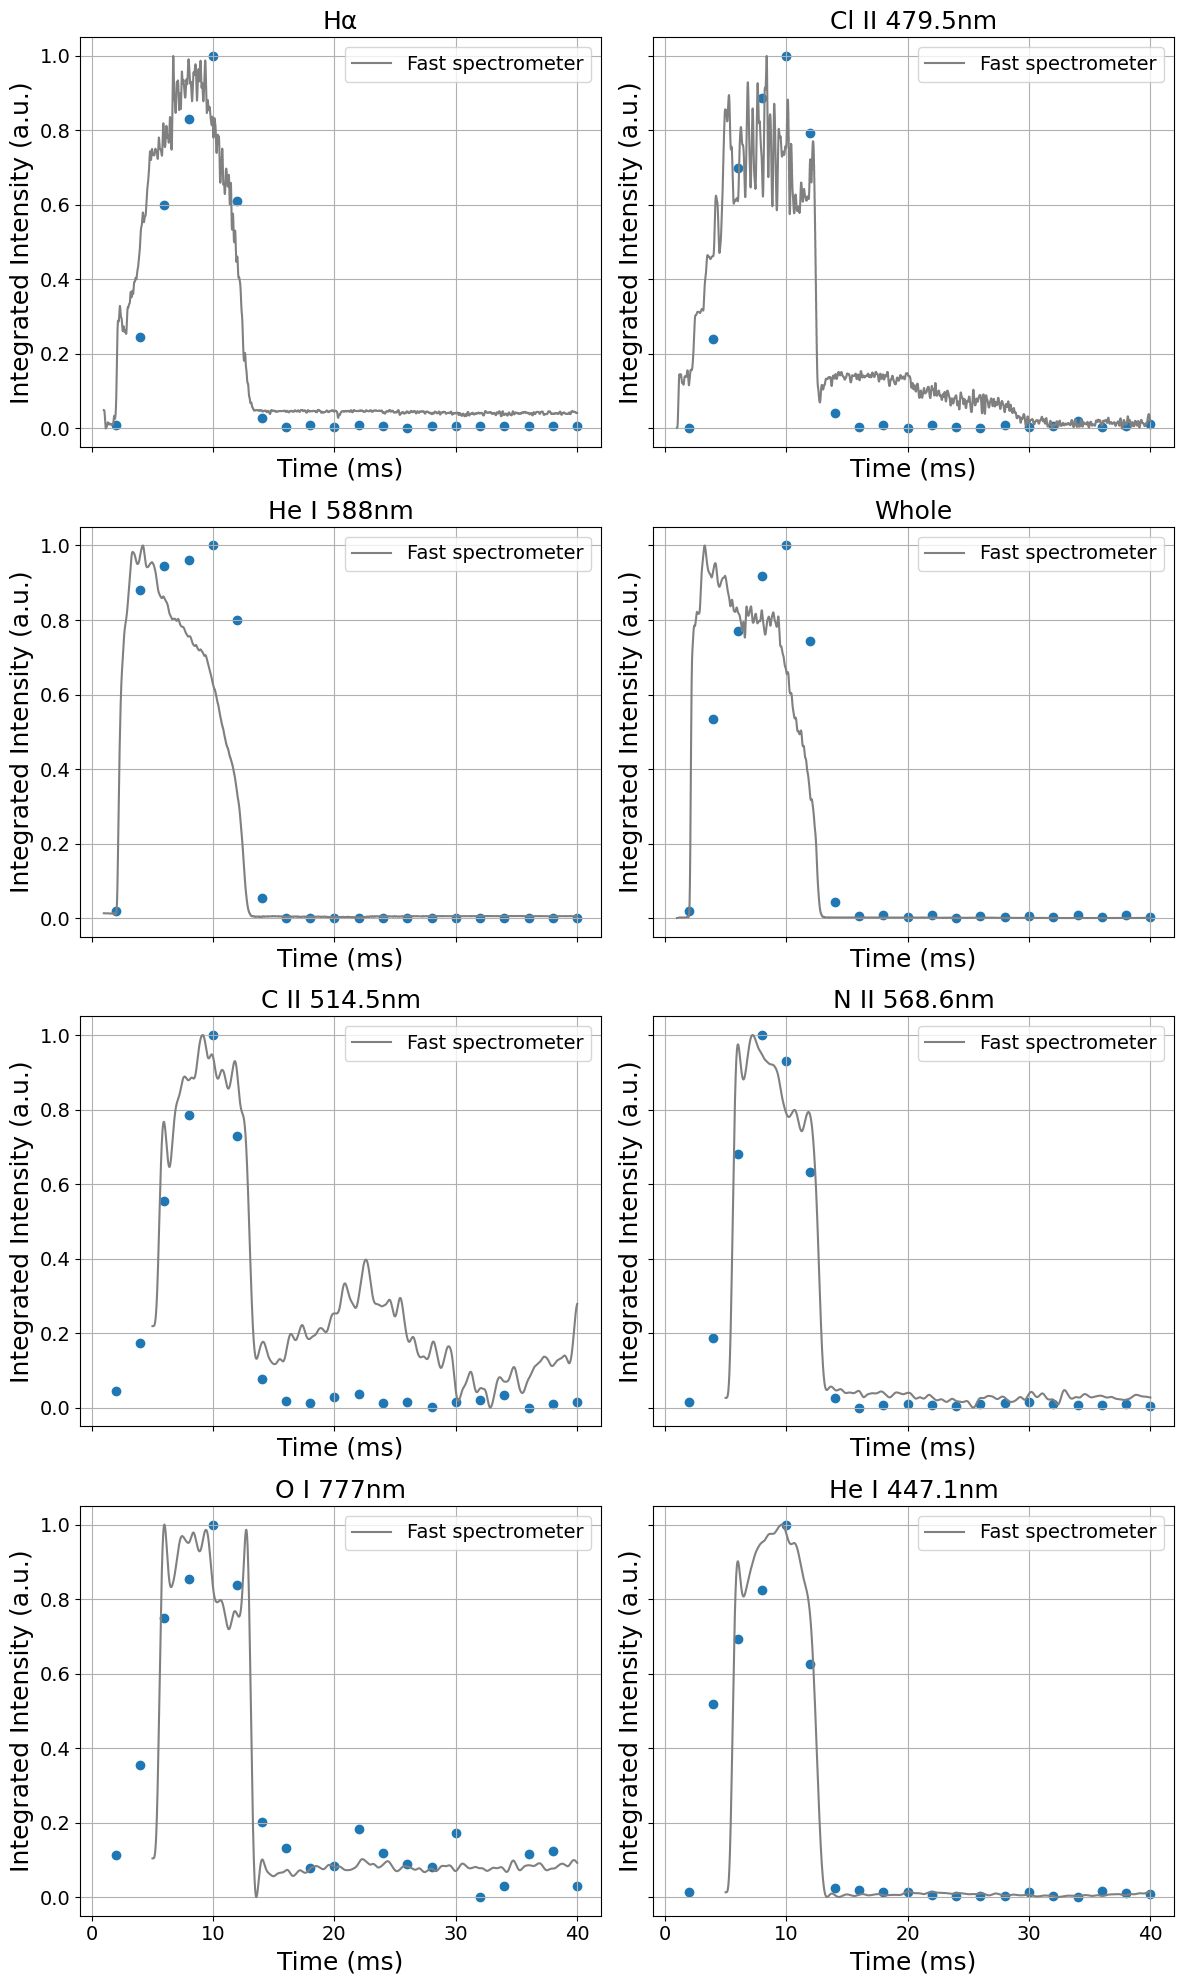

In [7]:
peaks = [
  {
    "name": "Hα",
    "wavelength": 656.28,
    "fwhm": 10,
    "fs_data": data["Hα"]
  },
  {
    "name": "Cl II 479.5nm",
    "wavelength": 479.5,
    "fwhm": 10,
    "fs_data": data["Cl II 479.5nm"]
  },
  {
    "name": "He I 588nm",
    "wavelength": 588.0,
    "fwhm": 10,
    "fs_data": data["He I 588nm"]
  },
  {
    "name": "Whole",
    "wavelength": 500.0,
    "fwhm": 300,
    "fs_data": data["Whole"]
  },
  {
    "name": "C II 514.5nm",
    "wavelength": 514.5,
    "fwhm": 10,
    "fs_data": data["C II 514.5nm"]
  },
  {
    "name": "N II 568.6nm",
    "wavelength": 568.6,
    "fwhm": 10,
    "fs_data": data["N II 568.6nm"]
  },
  {
    "name": "O I 777nm",
    "wavelength": 777.0,
    "fwhm": 10,
    "fs_data": data["O I 777nm"]
  },
  {
    "name": "He I 447.1nm",
    "wavelength": 447.1,
    "fwhm": 10,
    "fs_data": data["He I 447.1nm"]
  }
]

compare_spectrometer(peaks, Wavelengths, Spectra)

In [8]:
from scipy import signal

# Extract Hα signal data
ha_df = data["Hα"]
t_ha = ha_df.iloc[:, 0].values  # time in seconds
u_ha = ha_df.iloc[:, 1].values  # intensity

# Spectrogram parameters
fs = 100e3  # Sampling frequency (100 kHz)
nperseg = 512  # Length of each segment for STFT
noverlap = nperseg // 2  # Overlap between segments

# Compute the spectrogram using Short-Time Fourier Transform
frequencies, times, Sxx = signal.spectrogram(u_ha, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Create the spectrogram plot
%matplotlib qt
fig, ax = plt.subplots(figsize=(14, 8))

# Plot spectrogram with logarithmic scale for better visibility
pcm = ax.pcolormesh(times * 1e3, frequencies, 10 * np.log10(Sxx), 
                     shading='gouraud', cmap='viridis')

ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [ms]')
ax.set_title(f'Spectrogram of Hα Signal - Shot {shotno}')
ax.set_ylim(0, 5000)  # Focus on 0-5 kHz range
ax.set_xlim(0, 15)  # Match the time range from the previous plots

# Add colorbar
cbar = fig.colorbar(pcm, ax=ax, label='Power Spectral Density [dB]')

plt.tight_layout()
plt.show()
